In [1]:
# Activating the BehavioralDeePC package
using Pkg
Pkg.activate("..")
using Plots, LaTeXStrings, LinearAlgebra
using DataEnabledControl

  Activating project at `~/Documents/GitHub/DataEnabledControl`


In [2]:
# Define the data generating system (for the purpose of simulation)
Q = 5.0 * diagm([1,1])
R = 1.0 * diagm([1,1])
N = 10
function state_space_example(u, x₀)
    A = [0.8 0.2 -0.1; 0 0.85 -0.3; 0 0 0.9]
    B = [0 0; 0 1; 1 0]
    x₁ = A * x₀ + B * u + 0.0 * randn(3)
    y = x₁[1:2,:]
    x₀ = x₁
    return y, x₀
end

state_space_example (generic function with 1 method)

In [3]:
# Adjust the following function to suit your problem formulation
function closed_loop_sim(T_sim, Tᵢₙᵢ, x₀)
    # Initial recorded memory length (to infer initial conditions implicitly)
        Uᵢₙᵢ = zeros(2,Tᵢₙᵢ)
        Yᵢₙᵢ = zeros(2,Tᵢₙᵢ)
        for i in 1:Tᵢₙᵢ
            u₁ = Uᵢₙᵢ[:,i]
            y₁, x₀ = state_space_example(u₁, x₀)
            Yᵢₙᵢ[:,i] = y₁
        end
    
    # Run closed-loop simulation, initialized by the above sequences (as initial conditions)
        U_rec = zeros(size(Uᵢₙᵢ)[1], T_sim)
        Y_rec = zeros(size(Yᵢₙᵢ)[1], T_sim)
        Constrained = true
        prob = DeePC_struct(Q, R, N, U, Y, Tᵢₙᵢ,Constrained)
        # In this case 
        if Constrained
            Ay = 1.0 * I(2)
            by = 2.0 * ones(2)
            Au = bu = nothing
        end
        prob.constraintMatrices = ConstraintMatrices(Ay, by, Au, bu)
        for i in 1:T_sim
            Uv = vec(Uᵢₙᵢ)
            Yv = vec(Yᵢₙᵢ)
            uₜ, yₜ = run_DeePC(prob, Uv, Yv, slack_var = false, λy=100.0, λg=1.0)
        
            # First control only
            u₁ = uₜ[:,1]
            Uᵢₙᵢ[:,1:end-1] = Uᵢₙᵢ[:,2:end]
            Uᵢₙᵢ[:,end] = u₁
            y₁, x₀ = state_space_example(u₁, x₀)
            Yᵢₙᵢ[:,1:end-1] = Yᵢₙᵢ[:,2:end]
            Yᵢₙᵢ[:,end] = y₁
            
            U_rec[:,i] = u₁
            Y_rec[:,i] = y₁
        end
    return U_rec, Y_rec, x₀
    end
    

closed_loop_sim (generic function with 1 method)

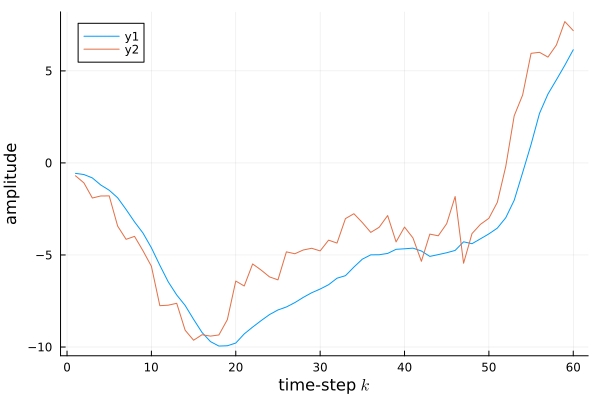

In [4]:
# Collect persistently excited input/output data
T = 60
U = randn(2,T)
Y = zeros(size(U))
x₀ = randn(3)
for i in 1:T
    y, x₀ = state_space_example(U[:,i], x₀)
    Y[:,i] = y
end
plot(Y', xlabel=L"time-step $k$", ylabel="amplitude")

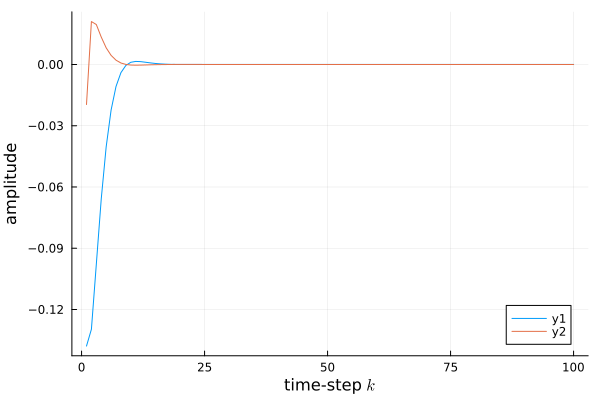

In [5]:
# Apply DeePC for regulation problem
Tᵢₙᵢ = 3
T_sim = 100
x₀ = randn(3) #randn(3) .+ 5
U_rec, Y_rec, x₀ = closed_loop_sim(T_sim, Tᵢₙᵢ, x₀);
plot(Y_rec', xlabel=L"time-step $k$", ylabel="amplitude")